In [2]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import re

from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tf-Idf and Clustering packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string
# NTLK functions
import nltk
from nltk.corpus import stopwords
from nltk import tokenize as tok
from nltk.stem.snowball import SnowballStemmer # load nltk's SnowballStemmer as variabled 'stemmer'

In [3]:
df = pd.read_csv("data/Volvo_edmunds_10yrs.csv",lineterminator='\n').iloc[:,1:]

In [4]:
df["Review"][0]

"In evaluating a car, first you define the mission.\nNo car can be all things.\nIf you want a Corvette, you understand that it can't have the gas mileage of a Prius. \n\nThis is the T5 C30 with 17 in wheels:\n\nA small, nimble car with an appealing and distinctive aesthetic that coddles the driver with excellent ride dynamics and great interior design.\n \nIt is not trying to be a track car.\nIt is 2+2 GT road car.\nIt gets you through your driving day with a minimum of fatigue and a maximum of bliss.\nIt has the quickness and agility to squeeze through traffic, yet still has a cabin that is quiet and comfortable.\nPlus, it feels like quality, it is nice to look at, and it is just fun to drive. "

In [5]:
isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)
isRTusername = re.compile(r'^RT+[\s]+(@[\w_]+:)',re.VERBOSE | re.IGNORECASE) #r'^RT+[\s]+(@[\w_]+:)'
isEntity = re.compile(r'@[\w_]+', re.VERBOSE | re.IGNORECASE)

In [6]:
# Helper functions
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) 

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
     
        
def clean_tweet(row):
    row = isURL.sub("",row)
    row = isRTusername.sub("",row)
    row = isEntity.sub("",row)
    return row

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
df["review_clean"] = df['Review'].apply(lambda row:clean_tweet(row))
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  
df['review_clean'] = df['review_clean'].str.replace(RE_PUNCTUATION, "")
df.head()

,Vehicle_model,Vehicle_Year,Vehicle_Rating,Review_Date,Author_Name,Vehicle_Name,Helpful_weight,Review_Title,Customer_Rating,Review,review_clean
0,C30,2011,4.8,06/12/2011,califas,T5 2dr Hatchback (2.5L 5cyl Turbo 6M),23 of 23 people found this review helpful,Great Driving Experience,4.88,"In evaluating a car, first you define the miss...",In evaluating a car first you define the missi...
1,C30,2011,4.8,10/17/2010,Lauren,T5 2dr Hatchback (2.5L 5cyl Turbo 6M),14 of 14 people found this review helpful,Forget Mini check out Volvo,4.88,"I thought I loved my 2007 Mini S convertible, ...",I thought I loved my 2007 Mini S convertible b...
2,C30,2011,4.8,09/30/2011,jersite,T5 2dr Hatchback (2.5L 5cyl Turbo 6M),11 of 11 people found this review helpful,Great Car!,4.75,Have had my 2011 Volvo C30 for a little over a...,Have had my 2011 Volvo C30 for a little over a...
3,C30,2011,4.8,06/04/2010,Robert James G,T5 2dr Hatchback (2.5L 5cyl Turbo 6M),10 of 10 people found this review helpful,Get it for what it is: a premium hatch.,4.75,I've read plenty of reviews stating how this c...,Ive read plenty of reviews stating how this ca...
4,C30,2011,4.8,08/18/2011,rsoldier97,R-Design 2dr Hatchback (2.5L 5cyl Turbo 6M),10 of 10 people found this review helpful,HOT!! Volvo C30 R-Design,4.50,I test drove several cars to include the Volks...,I test drove several cars to include the Volks...


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [9]:
from textblob import TextBlob

In [10]:
df.columns

Index(['Vehicle_model', 'Vehicle_Year', 'Vehicle_Rating', 'Review_Date',
       'Author_Name', 'Vehicle_Name', 'Helpful_weight', 'Review_Title',
       'Customer_Rating', 'Review', 'review_clean'],
      dtype='object')

In [11]:
df["review_clean"]

0       In evaluating a car first you define the missi...
1       I thought I loved my 2007 Mini S convertible b...
2       Have had my 2011 Volvo C30 for a little over a...
3       Ive read plenty of reviews stating how this ca...
4       I test drove several cars to include the Volks...
                              ...                        
1074    We have the 6 passenger momentum t8 hybrid wit...
1075    2018 XC60 upgraded to 2020 XC90 in June 2020 Q...
1076    I was disappointed once I finally test drove t...
1077    I was very excited when I first leased the 202...
1078    Love the car Got the 6 person version and it w...
Name: review_clean, Length: 1079, dtype: object

In [12]:
senti_df = df[["review_clean","Customer_Rating"]]

In [13]:
polarity = []
subjectivity = []
for each in senti_df["review_clean"] :
     text = TextBlob(each)
     polarity.append(text.sentiment.polarity)
     subjectivity.append(text.sentiment.subjectivity)

In [14]:
senti_df["polarity"] = polarity

In [15]:
# train_pos = senti_df[senti_df['polarity'] > 0 ]
# train_pos = train_pos['review_clean']
# train_neg = senti_df[senti_df['polarity'] <= 0 ]
# train_neg = train_neg['review_clean']
# stopwords_set = set(stopwords.words("english"))

# def wordcloud_draw(data, color = 'black'):
#     words = ' '.join(data)
#     cleaned_word = " ".join([word for word in words.split()
#                             if 'http' not in word
#                                 and not word.startswith('car')
#                                 and not word.startswith('volvo')
#                                 and not word.startswith('drive')
#                                 and not word.startswith('vehicle')

#                                 and not word.startswith('Volvo')
#                                 and word not in stopwords_set
#                                 and not TextBlob(word).sentiment.polarity !=0
#                                 # and not TextBlob(word).sentiment.polarity <= - 0.6
#                                 and word != 'RT'
#                             ])
#     wordcloud = WordCloud(stopwords=STOPWORDS,
#                       background_color=color,
#                       width=2500,
#                       height=2000
#                      ).generate(cleaned_word)
#     plt.figure(1,figsize=(13, 13))
#     plt.imshow(wordcloud)
#     plt.axis('off')
#     plt.show()
    
# print("Positive words")
# wordcloud_draw(train_pos,'white')
# print("Negative words")
# wordcloud_draw(train_neg)


In [16]:
df["review_clean"][0]

'In evaluating a car first you define the mission\nNo car can be all things\nIf you want a Corvette you understand that it cant have the gas mileage of a Prius \n\nThis is the T5 C30 with 17 in wheels\n\nA small nimble car with an appealing and distinctive aesthetic that coddles the driver with excellent ride dynamics and great interior design\n \nIt is not trying to be a track car\nIt is 22 GT road car\nIt gets you through your driving day with a minimum of fatigue and a maximum of bliss\nIt has the quickness and agility to squeeze through traffic yet still has a cabin that is quiet and comfortable\nPlus it feels like quality it is nice to look at and it is just fun to drive '

In [17]:

number_topics = 10
number_words = 5

corpus = df['review_clean'].tolist()
    # print(corpus)
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=0.00, stop_words="english", tokenizer=tokenize_only) # Use tf (raw term count) features for LDA.
tf = tf_vectorizer.fit_transform(corpus)

# Create and fit the LDA model
model = LDA(n_components=number_topics, n_jobs=-1)
id_topic = model.fit(tf)
# Print the topics found by the LDA model
print("Topics found via LDA:")
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=model, n_words=number_words)        
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]

df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

df_topic_keywords = df_topic_keywords.reset_index()
df_topic_keywords['topic_index'] = df_topic_keywords['index'].str.split(' ', n = 1, expand = True)[[1]].astype('int')
print(df_topic_keywords)
    
############ get the dominat topic for each document in a data frame ###############
# Create Document — Topic Matrix
lda_output = model.transform(tf)
# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]
    
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic   
df_document_topic = df_document_topic.reset_index()
        
df_document_topic

Topics found via LDA:
     index Word 0 Word 1  Word 2   Word 3   Word 4  topic_index
0  Topic 0    car  volvo    time    miles    drive            0
1  Topic 1    car  volvo   miles    great     just            1
2  Topic 2    car  volvo   great     like    drive            2
3  Topic 3    car  seats  engine     feel     seat            3
4  Topic 4    car  volvo       s        t  vehicle            4
5  Topic 5    car  volvo    seat  vehicle    great            5
6  Topic 6  volvo  makes     car    trunk     good            6
7  Topic 7    car   like    just     rear      gas            7
8  Topic 8    car  volvo  issues  vehicle      new            8
9  Topic 9   xc90    gas    like  driving    volvo            9


,index,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,Doc0,0.00,0.50,0.49,0.0,0.00,0.00,0.0,0.00,0.00,0.0,1
1,Doc1,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.98,0.00,0.0,7
2,Doc2,0.00,0.00,0.73,0.0,0.00,0.00,0.0,0.00,0.26,0.0,2
3,Doc3,0.00,0.00,0.68,0.3,0.00,0.00,0.0,0.00,0.00,0.0,2
4,Doc4,0.57,0.00,0.41,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1074,Doc1074,0.20,0.00,0.19,0.0,0.60,0.00,0.0,0.00,0.00,0.0,4
1075,Doc1075,0.00,0.00,0.51,0.0,0.00,0.47,0.0,0.00,0.00,0.0,2
1076,Doc1076,0.00,0.00,0.28,0.0,0.69,0.00,0.0,0.00,0.00,0.0,4
1077,Doc1077,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.96,0.0,8


In [18]:
# Load the regular expression library
import re
# Remove punctuation
df['review_clean'] = df['review_clean'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['review_clean'] = df['review_clean'].map(lambda x: x.lower())
# Print out the first rows of papers
df['review_clean'].head()

0    in evaluating a car first you define the missi...
1    i thought i loved my 2007 mini s convertible b...
2    have had my 2011 volvo c30 for a little over a...
3    ive read plenty of reviews stating how this ca...
4    i test drove several cars to include the volks...
Name: review_clean, dtype: object

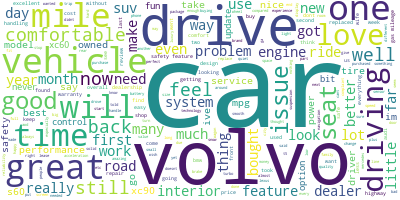

In [19]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['review_clean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [24]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['review_clean'])
# Visualise the 10 most common words
# plot_10_most_common_words(count_data, count_vectorizer)
count_data.data

array([1, 5, 1, ..., 1, 1, 1])

In [ ]:
####

In [32]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [34]:
stemmer = SnowballStemmer("english")

In [35]:
preprocess(df["review_clean"][0])

['evalu',
 'defin',
 'mission',
 'thing',
 'want',
 'corvett',
 'understand',
 'mileag',
 'prius',
 'wheel',
 'small',
 'nimbl',
 'appeal',
 'distinct',
 'aesthet',
 'coddl',
 'driver',
 'excel',
 'ride',
 'dynam',
 'great',
 'interior',
 'design',
 'tri',
 'track',
 'road',
 'get',
 'drive',
 'minimum',
 'fatigu',
 'maximum',
 'bliss',
 'quick',
 'agil',
 'squeez',
 'traffic',
 'cabin',
 'quiet',
 'comfort',
 'plus',
 'feel',
 'like',
 'qualiti',
 'nice',
 'look',
 'drive']

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)


In [ ]:
####

In [108]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

/Users/sixumeng/opt/anaconda3/envs/VSMS/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Topics found via LDA:

Topic #0:
car volvo great seats good drive comfortable driving like safety

Topic #1:
car volvo engine miles new vehicle dealer drive time driving

Topic #2:
car volvo buy just cars new driving xc90 owned vehicle

Topic #3:
car volvo great like vehicle driving miles just drive new

Topic #4:
car like volvo great drive love comfortable seats really just


In [110]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
# with open(LDAvis_data_filepath, 'w') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath) as f:
#     LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

CPU times: user 5.02 s, sys: 46.9 ms, total: 5.07 s
Wall time: 5.7 s
